# 

In [16]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import (
    ElectraTokenizerFast, ElectraForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding,
    TrainerCallback, EarlyStoppingCallback
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
device

device(type='cpu')

In [18]:
# 📂 Load dataset
df = pd.read_csv("../dataset.csv")
df.columns = df.columns.str.strip()
df = df.iloc[1:]
df = df[df['Level'].isin([0, 1, 2, 3])]
df['Level'] = df['Level'].astype(int)
df.rename(columns={'Level': 'labels'}, inplace=True)

In [19]:
# 🧪 Train-test split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=42)

# 📤 Convert to HF Datasets
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

In [20]:
# 🔠 Tokenization
tokenizer = ElectraTokenizerFast.from_pretrained("google/electra-base-discriminator")

def tokenize_function(example):
    return tokenizer(example["Response"], truncation=True)

train_ds = train_ds.map(tokenize_function, batched=True)
test_ds = test_ds.map(tokenize_function, batched=True)

Map:   0%|          | 0/4112 [00:00<?, ? examples/s]

Map:   0%|          | 0/1029 [00:00<?, ? examples/s]

In [21]:
# 📦 Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 🧠 Load ELECTRA model
model = ElectraForSequenceClassification.from_pretrained("google/electra-base-discriminator", num_labels=4).to(device)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
# 📊 Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.argmax(torch.tensor(logits), axis=-1).numpy()
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "macro_precision": precision,
        "macro_recall": recall,
        "macro_f1": f1,
    }

In [23]:
# 🧩 Accuracy logging callback
class AccuracyTrackerCallback(TrainerCallback):
    def __init__(self, trainer_ref):
        self.trainer = trainer_ref
        self.train_accuracies = []
        self.eval_accuracies = []

    def on_epoch_end(self, args, state, control, **kwargs):
        train_output = self.trainer.predict(self.trainer.train_dataset)
        train_preds = train_output.predictions.argmax(axis=1)
        train_labels = train_output.label_ids
        train_acc = accuracy_score(train_labels, train_preds)
        self.train_accuracies.append(train_acc)

        eval_output = self.trainer.predict(self.trainer.eval_dataset)
        eval_preds = eval_output.predictions.argmax(axis=1)
        eval_labels = eval_output.label_ids
        eval_acc = accuracy_score(eval_labels, eval_preds)
        self.eval_accuracies.append(eval_acc)

        print(f"\n📊 Epoch {state.epoch:.0f} → Train Acc: {train_acc:.4f} | Val Acc: {eval_acc:.4f}")

In [24]:
# ⚙️ Training arguments
training_args = TrainingArguments(
    output_dir="./electra_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    logging_dir="./electra_logs",
    logging_steps=50,
    save_total_limit=2
)

In [25]:
# 📦 Initialize trainer
accuracy_logger = AccuracyTrackerCallback(None)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[
        accuracy_logger,
        EarlyStoppingCallback(early_stopping_patience=7)
    ]
)

accuracy_logger.trainer = trainer

/tmp/ipykernel_81938/2637693720.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [26]:
# 🕒 Training
start_time = time.time()
trainer.train()
end_time = time.time()
training_time = end_time - start_time
print(f"Training completed in {training_time:.2f} seconds")

Epoch,Training Loss,Validation Loss,Accuracy,Macro Precision,Macro Recall,Macro F1
1,0.437000,0.301980,0.905734,0.901588,0.888027,0.893107
2,0.235600,0.325301,0.921283,0.915598,0.913025,0.912694
3,0.116600,0.260183,0.938776,0.933059,0.935882,0.932756
4,0.057900,0.351003,0.941691,0.936293,0.941168,0.937522
5,0.042900,0.439228,0.940719,0.934757,0.940429,0.936543
6,0.052900,0.403588,0.942663,0.943883,0.934762,0.938523
7,0.029900,0.304017,0.959184,0.955618,0.955654,0.955571
8,0.019900,0.345526,0.948494,0.944820,0.944517,0.944586
9,0.024500,0.444055,0.939747,0.938666,0.936918,0.936362
10,0.000200,0.426157,0.946550,0.940991,0.943856,0.941567



📊 Epoch 1 → Train Acc: 0.9321 | Val Acc: 0.9057

📊 Epoch 2 → Train Acc: 0.9652 | Val Acc: 0.9213

📊 Epoch 3 → Train Acc: 0.9844 | Val Acc: 0.9388

📊 Epoch 4 → Train Acc: 0.9929 | Val Acc: 0.9417

📊 Epoch 5 → Train Acc: 0.9971 | Val Acc: 0.9407

📊 Epoch 6 → Train Acc: 0.9966 | Val Acc: 0.9427

📊 Epoch 7 → Train Acc: 0.9998 | Val Acc: 0.9592

📊 Epoch 8 → Train Acc: 0.9998 | Val Acc: 0.9485

📊 Epoch 9 → Train Acc: 0.9995 | Val Acc: 0.9397

📊 Epoch 10 → Train Acc: 0.9995 | Val Acc: 0.9466

📊 Epoch 11 → Train Acc: 0.9993 | Val Acc: 0.9524

📊 Epoch 12 → Train Acc: 0.9995 | Val Acc: 0.9504

📊 Epoch 13 → Train Acc: 1.0000 | Val Acc: 0.9475

📊 Epoch 14 → Train Acc: 1.0000 | Val Acc: 0.9572
Training completed in 4548.75 seconds


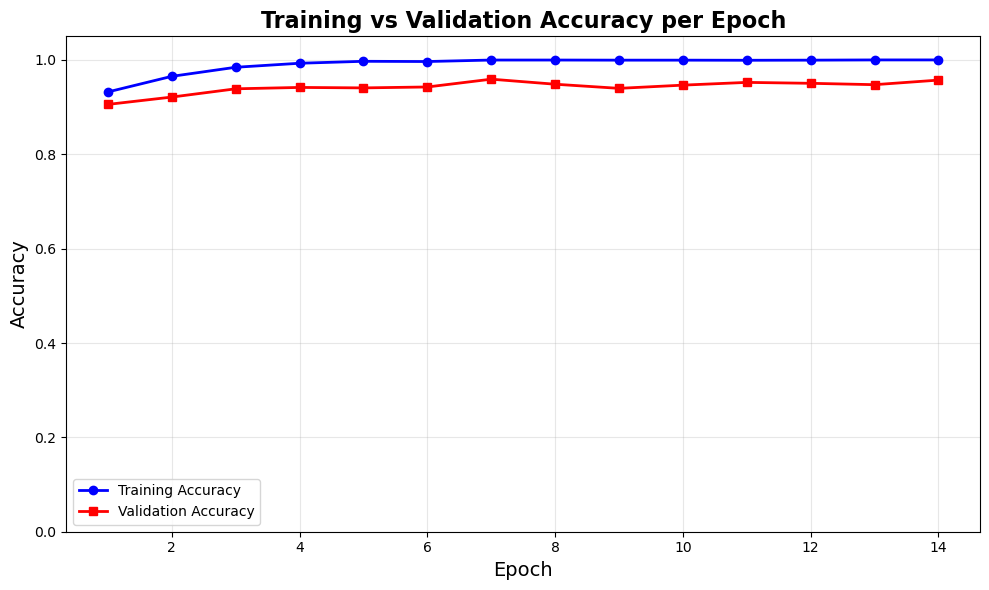

In [28]:
# 📈 Plot Training vs Validation Accuracy
train_accs = accuracy_logger.train_accuracies
val_accs = accuracy_logger.eval_accuracies
epochs = range(1, len(train_accs) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accs, label="Training Accuracy", marker='o', linewidth=2, color='blue')
plt.plot(epochs, val_accs, label="Validation Accuracy", marker='s', linewidth=2, color='red')
plt.title("Training vs Validation Accuracy per Epoch", fontsize=16, fontweight='bold')
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.ylim(0, 1.05)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


🔍 Classification Report:

              precision    recall  f1-score   support

     Level 0     0.9682    0.9795    0.9738       342
     Level 1     0.9614    0.9522    0.9567       209
     Level 2     0.9146    0.9333    0.9239       195
     Level 3     0.9783    0.9576    0.9679       283

    accuracy                         0.9592      1029
   macro avg     0.9556    0.9557    0.9556      1029
weighted avg     0.9594    0.9592    0.9592      1029


📊 Final Test Accuracy: 0.9592


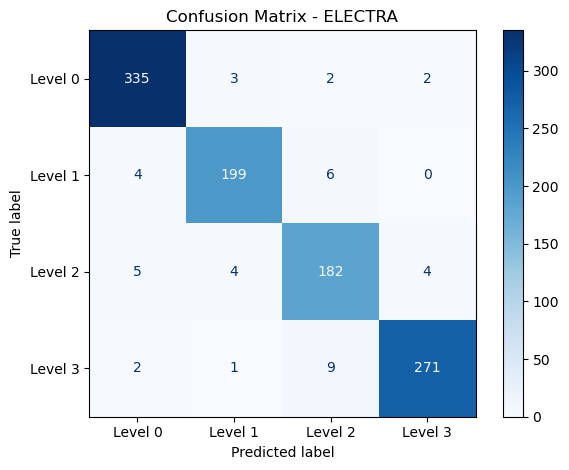

('./electra_saved/tokenizer_config.json',
 './electra_saved/special_tokens_map.json',
 './electra_saved/vocab.txt',
 './electra_saved/added_tokens.json',
 './electra_saved/tokenizer.json')

In [29]:

# 🔍 Final Evaluation
preds = trainer.predict(test_ds)
y_pred = preds.predictions.argmax(axis=1)
y_true = preds.label_ids

print("\n🔍 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Level 0", "Level 1", "Level 2", "Level 3"], digits=4))
print(f"\n📊 Final Test Accuracy: {accuracy_score(y_true, y_pred):.4f}")

# 📉 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Level 0", "Level 1", "Level 2", "Level 3"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - ELECTRA")
plt.tight_layout()
plt.show()

# 💾 Save model and tokenizer
trainer.save_model("./electra_saved")
tokenizer.save_pretrained("./electra_saved")

In [ ]:
#Training started on: 3:54 AM